# Step 1: Data Acquisition

## Article Page Views API 

##### The data given in the excel file has been converted to csv and uploaded on Juoyter lab for ease of access.

### Collect the articles to use

In [33]:
import pandas as pd

In [34]:
articles= pd.read_csv('DinoData.csv')

In [35]:
articles['name'][0]='Coelosaurus antiquus'

In [36]:
articles_list=[x for x in articles.name]

In [37]:
articles.head()

,name,url
0,Coelosaurus antiquus,https://en.wikipedia.org/wiki/”Coelosaurus”_an...
1,Aachenosaurus,https://en.wikipedia.org/wiki/Aachenosaurus
2,Aardonyx,https://en.wikipedia.org/wiki/Aardonyx
3,Abdarainurus,https://en.wikipedia.org/wiki/Abdarainurus
4,Abditosaurus,https://en.wikipedia.org/wiki/Abditosaurus


In [12]:
# 
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
import operator

The example relies on some constants that help make the code a bit more readable.

In [13]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<ananya03@uw.edu>, UW, MSDS DATA 512 - AUTUMN 2022',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}
ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

params=[ARTICLE_PAGEVIEWS_PARAMS_DESKTOP,ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB,ARTICLE_PAGEVIEWS_PARAMS_MOBILE_APP]

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter most likely to change is the article_title.

In [14]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace('"','').replace(' ','_'))
    request_template['article'] = article_title_encoded
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [15]:
articles.name[1]

'Aachenosaurus'

In [264]:
print("Getting pageview data for: ",articles.name[0])
views_test = request_pageviews_per_article('joe_biden',request_template=ARTICLE_PAGEVIEWS_PARAMS_MOBILE_WEB)

Getting pageview data for:  Coelosaurus antiquus


### Extract the relevant information from wikipedia

In [19]:
data_mobile_app={}
data_desktop={}
data_mobile_web={}
for param in params:
    print(' checking for param {}'.format(param))
    data={'items':[]}
    for article in articles_list:
        views = request_pageviews_per_article(article,request_template=param)
        # try:
        # print(views)
        data['items']=data['items']+views['items']
    data_dict=data
    if param['access']=='mobile-web':
        with open("mobile_web.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_mobile = json.dumps(data_dict, indent=4)
    if param['access']=='desktop':
        with open("desktop.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_desktop = json.dumps(data_dict, indent=4)
    else:
        with open("mobile_app.json", "w") as outfile:
            json.dump(data_dict, outfile)
            json_desktop = json.dumps(data_dict, indent=4)
       

 checking for param {'project': 'en.wikipedia.org', 'access': 'desktop', 'agent': 'user', 'article': '', 'granularity': 'monthly', 'start': '2015070100', 'end': '2022093000'}
 checking for param {'project': 'en.wikipedia.org', 'access': 'mobile-web', 'agent': 'user', 'article': 'joe_biden', 'granularity': 'monthly', 'start': '2015070100', 'end': '2022093000'}
 checking for param {'project': 'en.wikipedia.org', 'access': 'mobile-app', 'agent': 'user', 'article': '', 'granularity': 'monthly', 'start': '2015070100', 'end': '2022093000'}


Above output should show dictionaries with views per month

### Temp - Convert json to csv for adding mobile and web

In [38]:
# function to convert json to csv

import json
import csv
def json_to_csv(input_file,output_file):
    
    # Opening JSON file and loading the data
    # into the variable data
    with open(input_file) as json_file:
        data = json.load(json_file)

    dino_data = data['items']
    print(dino_data[2])
    # now we will open a file for writing
    data_file = open(output_file, 'w')

    # create the csv writer object
    csv_writer = csv.writer(data_file)

    # Counter variable used for writing
    # headers to the CSV file
    count = 0

    for dino in dino_data:
        if count == 0:
            # Writing headers of CSV file
            header = dino.keys()
            csv_writer.writerow(header)
            count += 1
        # Writing data of CSV file
        csv_writer.writerow(dino.values())

    data_file.close()

In [21]:
json_to_csv('mobile_web.json','mobile_web.csv')
json_to_csv('mobile_app.json','mobile_app.csv')
json_to_csv('desktop.json','desktop.csv')

{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'mobile-web', 'agent': 'user', 'views': 9}
{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'mobile-app', 'agent': 'user', 'views': 2}
{'project': 'en.wikipedia', 'article': 'Coelosaurus_antiquus', 'granularity': 'monthly', 'timestamp': '2015090100', 'access': 'desktop', 'agent': 'user', 'views': 80}


In [182]:
mobile_web=pd.read_csv('mobile_web.csv')
mobile_app=pd.read_csv('mobile_app.csv')
desktop=pd.read_csv('desktop.csv')

### Sanity check for the csv files

In [183]:
mobile_web.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-web,user,16
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-web,user,12
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-web,user,9
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-web,user,21
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-web,user,13


In [184]:
mobile_app.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-app,user,4
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-app,user,2
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-app,user,2
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-app,user,0
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-app,user,0


In [185]:
desktop.head()

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,desktop,user,79
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,desktop,user,62
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,desktop,user,80
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,desktop,user,66
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,desktop,user,72


#### Aggregate the datasets and calculate cumulative views

There are 3 datasets required: 
1. Mobile views (mobile views_mobile app)
2. Desktop views
3. Cumulative views month over month

In [269]:
mobile_agg = pd.concat([mobile_web,mobile_app],axis=0)
mobile_agg = mobile_agg.sort_values(by = ['article', 'timestamp'], ascending = True)


mobile = mobile_agg.groupby(by=['project','article','granularity','timestamp','agent']).agg({'views':'sum'}).reset_index()
mobile.columns = ['project','article','granularity','timestamp','agent','views']

In [270]:
mobile.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,443
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,412
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,283
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,794
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,311


In [222]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112697 entries, 0 to 112696
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   project      112697 non-null  object
 1   article      112697 non-null  object
 2   granularity  112697 non-null  object
 3   timestamp    112697 non-null  int64 
 4   agent        112697 non-null  object
 5   views        112697 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.0+ MB


In [288]:
desktop1=desktop.loc[:,['project','article','granularity','timestamp','agent','views']]

In [289]:
desktop1 = desktop1.sort_values(by = ['article', 'timestamp'], ascending = True)
desktop1.head()

,project,article,granularity,timestamp,agent,views
87,en.wikipedia,Aachenosaurus,monthly,2015070100,user,2671
88,en.wikipedia,Aachenosaurus,monthly,2015080100,user,13113
89,en.wikipedia,Aachenosaurus,monthly,2015090100,user,34235
90,en.wikipedia,Aachenosaurus,monthly,2015100100,user,5361
91,en.wikipedia,Aachenosaurus,monthly,2015110100,user,13502


In [225]:
all_access=pd.concat([mobile,desktop1],axis=0)

In [194]:
columns = ['project', 'article', 'granularity', 'timestamp', 'agent']
data = all_access.groupby(columns).sum().groupby('article').cumsum().reset_index()
data = data.sort_values(by = ['article', 'timestamp'], ascending = True)
data.head()

,project,article,granularity,timestamp,agent,views
0,en.wikipedia,Aachenosaurus,monthly,2015070100,user,3114
1,en.wikipedia,Aachenosaurus,monthly,2015080100,user,16639
2,en.wikipedia,Aachenosaurus,monthly,2015090100,user,51157
3,en.wikipedia,Aachenosaurus,monthly,2015100100,user,57312
4,en.wikipedia,Aachenosaurus,monthly,2015110100,user,71125


In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112697 entries, 0 to 112696
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   project      112697 non-null  object
 1   article      112697 non-null  object
 2   granularity  112697 non-null  object
 3   timestamp    112697 non-null  int64 
 4   agent        112697 non-null  object
 5   views        112697 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.0+ MB


### Store everything back in json because that is the required file type

There are 3 files required:
1. Monthly mobile access - dino_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json
2. Monthly desktop access - dino_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json
3. Monthly cumulative - dino_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json


In [196]:
def csv_to_json(df, jsonFilePath):
    result = df.to_json(orient="records")
    parsed = json.loads(result)
    with open(jsonFilePath, "w") as outfile:
            json.dump(parsed, outfile)

In [138]:
csv_to_json(mobile,'dino_monthly_mobile_201507-202209.json')
csv_to_json(desktop1,'dino_monthly_desktop_201507-202209.json')
csv_to_json(data,'dino_monthly_cumulative_201507-202209.json')

## Step 2: Analysis

### Instructions
**Maximum Average and Minimum Average** - The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).


#### 2.1

1. Calculate the average of article views over all the available months
2. Sort the data to get names with maximum and minimum average views
3. Filter data containing only these areicles obtained in the above step

#### Mobile

In [308]:
mobile_grp_avg = mobile.groupby(by=['article']).agg({'views':'mean'}).reset_index()
mobile_grp_avg.columns = ['article','avg_views']
mobile_grp_avg = mobile_grp_avg.sort_values(by='avg_views', ascending=False)

##### Store the min and max

In [309]:
min_article_mobile = mobile_grp_avg.iloc[-1,0]
max_article_mobile = mobile_grp_avg.iloc[0,0]
max_article_mobile

'Tyrannosaurus'

In [310]:
min_article_mobile

'Honghesaurus'

#### Desktop

In [311]:
desktop_grp_avg = desktop1.groupby(by=['article']).agg({'views':'mean'}).reset_index()
desktop_grp_avg.columns = ['article','avg_views']
desktop_grp_avg = desktop_grp_avg.sort_values(by='avg_views', ascending=False)

In [312]:
min_article_desktop = desktop_grp_avg.iloc[-1,0]
max_article_desktop = desktop_grp_avg.iloc[0,0]
max_article_desktop

'Tyrannosaurus'

In [313]:
min_article_desktop

'Honghesaurus'

### Plot the views over time for these 

In [314]:
import matplotlib.pyplot as plt

In [315]:
desktop1['timestamp_1'] = desktop1['timestamp'].apply(lambda x: str(x)[0:8])
desktop1['timestamp_1'] = desktop1['timestamp_1'].astype(int)
mobile['timestamp_1'] = mobile['timestamp'].apply(lambda x: str(x)[0:8])
mobile['timestamp_1'] = mobile['timestamp_1'].astype(int)

In [317]:
desktop1['timestamp_1'] = pd.to_datetime(desktop1['timestamp_1'], format='%Y%m%d').dt.strftime('%m/%d/%Y')
mobile['timestamp_1'] = pd.to_datetime(mobile['timestamp_1'], format='%Y%m%d').dt.strftime('%m/%d/%Y')

<ipython-input-323-78a61e04a08f>:16: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=10)


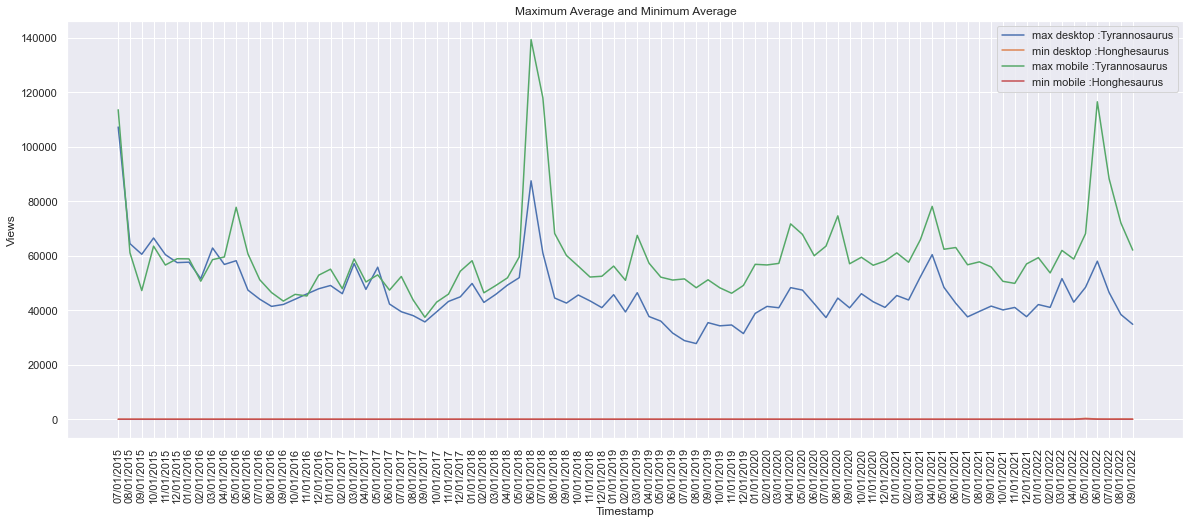

In [323]:
# plot 4 lines for articles with highest and lowest average views for desktop and mobile access
plt.figure(figsize = (20,10))
plt.plot(desktop1[desktop1['article'] == max_article_desktop].timestamp_1,\
         desktop1[desktop1['article'] == max_article_desktop].views, label = "max desktop :" + max_article_desktop)
plt.plot(desktop1[desktop1['article'] == min_article_desktop].timestamp_1,\
         desktop1[desktop1['article'] == min_article_desktop].views, label = "min desktop :" + min_article_desktop)
plt.plot(mobile[mobile['article'] == max_article_mobile].timestamp_1,\
         mobile[mobile['article'] == max_article_mobile].views, label = "max mobile :" + max_article_mobile)
plt.plot(mobile[mobile['article'] == min_article_mobile].timestamp_1,\
         mobile[mobile['article'] == min_article_mobile].views, label = "min mobile :" + min_article_mobile)


plt.xlabel('Timestamp')
plt.ylabel('Views')
plt.title('Maximum Average and Minimum Average')
plt.locator_params(nbins=10)
plt.legend()
plt.xticks(rotation ='vertical')
plt.subplots_adjust(bottom = 0.30)


# Save the plot as a png file
plt.savefig('2a.png')



**Top 10 Peak Page Views** - The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).


#### 2.2

1. Calculate the max views of articles
2. Find the top 10
3. Plot the top 10 peak page views

In [336]:
#top 10 articles for dekstop

desktop1['access']='desktop'
temp = desktop1.groupby('article')['views'].transform('max') == desktop1['views']
top_10_desktop=desktop1[temp].sort_values(by='views',ascending=False).iloc[:10,:]
top_10_desktop

,project,article,granularity,timestamp,agent,views,timestamp_1,access
855,en.wikipedia,Achelousaurus,monthly,2021020100,user,205150,02/01/2021,desktop
105162,en.wikipedia,Velociraptor,monthly,2015070100,user,135741,07/01/2015,desktop
103272,en.wikipedia,Tyrannosaurus,monthly,2015070100,user,107257,07/01/2015,desktop
43310,en.wikipedia,Halszkaraptor,monthly,2017120100,user,103251,12/01/2017,desktop
40057,en.wikipedia,Giganotosaurus,monthly,2022060100,user,62340,06/01/2022,desktop
93439,en.wikipedia,Spinosaurus,monthly,2015070100,user,61029,07/01/2015,desktop
60236,en.wikipedia,Lythronax,monthly,2020060100,user,57701,06/01/2020,desktop
68436,en.wikipedia,Nigersaurus,monthly,2020020100,user,57192,02/01/2020,desktop
17187,en.wikipedia,Borealopelta,monthly,2019090100,user,53831,09/01/2019,desktop
29668,en.wikipedia,Dilophosaurus,monthly,2018060100,user,53278,06/01/2018,desktop


In [337]:
#top 10 articles for mobile
mobile['access']='mobile'
temp = mobile.groupby('article')['views'].transform('max') == mobile['views']
top_10_mobile=mobile[temp].sort_values(by='views',ascending=False).iloc[:10,:]
top_10_mobile

,project,article,granularity,timestamp,agent,views,timestamp_1,access
68436,en.wikipedia,Nigersaurus,monthly,2020020100,user,235977,02/01/2020,mobile
28485,en.wikipedia,Deinocheirus,monthly,2021050100,user,234704,05/01/2021,mobile
40057,en.wikipedia,Giganotosaurus,monthly,2022060100,user,165007,06/01/2022,mobile
99962,en.wikipedia,Therizinosaurus,monthly,2022060100,user,155431,06/01/2022,mobile
105162,en.wikipedia,Velociraptor,monthly,2015070100,user,142284,07/01/2015,mobile
769,en.wikipedia,Achelousaurus,monthly,2021030100,user,140592,03/01/2021,mobile
103307,en.wikipedia,Tyrannosaurus,monthly,2018060100,user,139326,06/01/2018,mobile
17100,en.wikipedia,Borealopelta,monthly,2019090100,user,117282,09/01/2019,mobile
29716,en.wikipedia,Dilophosaurus,monthly,2022060100,user,78537,06/01/2022,mobile
9909,en.wikipedia,Argentinosaurus,monthly,2016120100,user,78437,12/01/2016,mobile


In [338]:
import seaborn as sns

In [339]:
df_top10_mobile=mobile[mobile['article'].isin(list(top_10_mobile.article))]
df_top10_desktop=desktop1[desktop1['article'].isin(list(top_10_desktop.article))]

top_10_all_access=pd.concat([df_top10_mobile,df_top10_desktop],axis=0)
top_10_all_access.head()

,project,article,granularity,timestamp,agent,views,timestamp_1,access
701,en.wikipedia,Achelousaurus,monthly,2015070100,user,464,07/01/2015,mobile
702,en.wikipedia,Achelousaurus,monthly,2015080100,user,321,08/01/2015,mobile
703,en.wikipedia,Achelousaurus,monthly,2015090100,user,301,09/01/2015,mobile
704,en.wikipedia,Achelousaurus,monthly,2015100100,user,322,10/01/2015,mobile
705,en.wikipedia,Achelousaurus,monthly,2015110100,user,325,11/01/2015,mobile


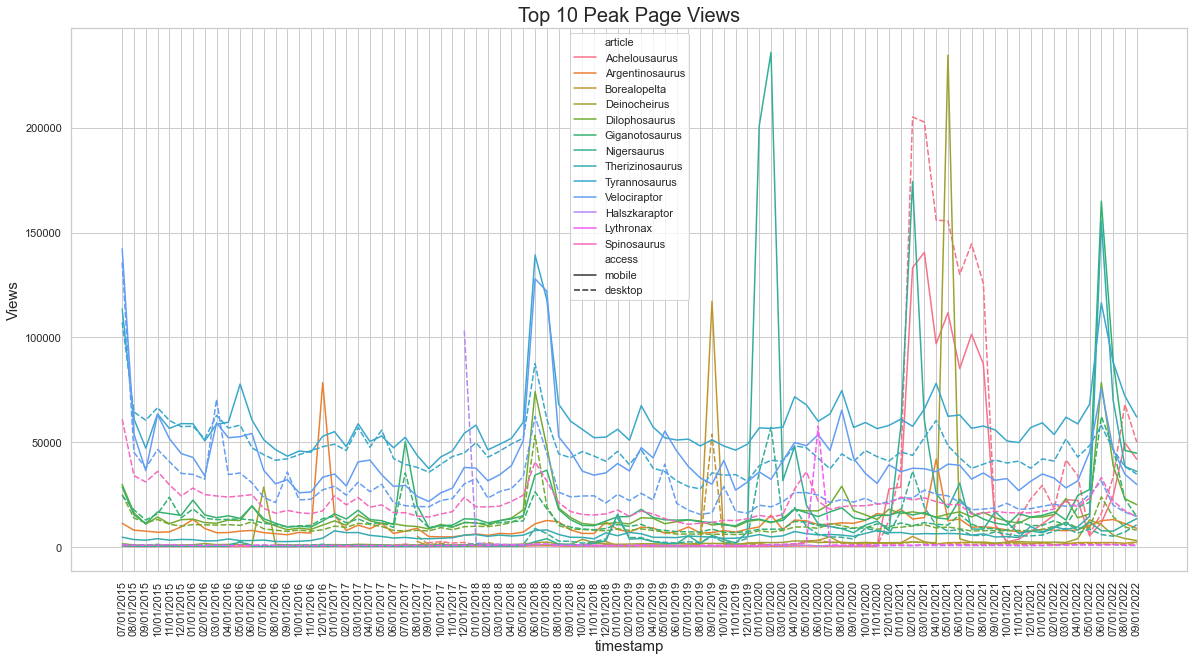

In [341]:
plt.figure(figsize = (20,10))
sns.set_style("whitegrid")
 
sns.lineplot(x='timestamp_1', y='views', 
             ci=None,hue='article',style='access', 
             data=top_10_all_access)
plt.title("Top 10 Peak Page Views", fontsize = 20)
plt.xlabel("timestamp", fontsize = 15)
plt.ylabel("Views", fontsize = 15)
plt.xticks(rotation ='vertical')
plt.legend()

# Save the plot as a png file
plt.savefig('2b.png')


plt.show()


**Fewest Months of Data** - The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


#### 2.3

1. Calculate the count of months for which data is available for each article
2. Get the top 10 articles that have the fewest months of data
3. Filter data containing only these articles obtained in the above step

In [343]:
#Fewest months of data
mobile_2c = mobile.groupby(by=['article']).agg({'timestamp':'nunique'}).reset_index()
mobile_2c.columns = ['article','months_count']
mobile_2c = mobile_2c.sort_values(by='months_count').iloc[:10]

In [344]:
mobile_2c

,article,months_count
414,Elemgasem,1
1295,Tuebingosaurus,1
617,Jakapil,2
791,Mbiresaurus,2
966,Perijasaurus,2
208,Bisticeratops,2
615,Iyuku,3
938,Paralitherizinosaurus,5
189,Bashanosaurus,7
403,Dzharaonyx,7


In [345]:
#Fewest months of data
desktop_2c = desktop1.groupby(by=['article']).agg({'timestamp':'nunique'}).reset_index()
desktop_2c.columns=['article','months_count']
desktop_2c=desktop_2c.sort_values(by='months_count').iloc[:10]

In [346]:
desktop_2c

,article,months_count
414,Elemgasem,1
1295,Tuebingosaurus,1
617,Jakapil,2
791,Mbiresaurus,2
966,Perijasaurus,2
208,Bisticeratops,2
615,Iyuku,3
938,Paralitherizinosaurus,5
189,Bashanosaurus,7
403,Dzharaonyx,7


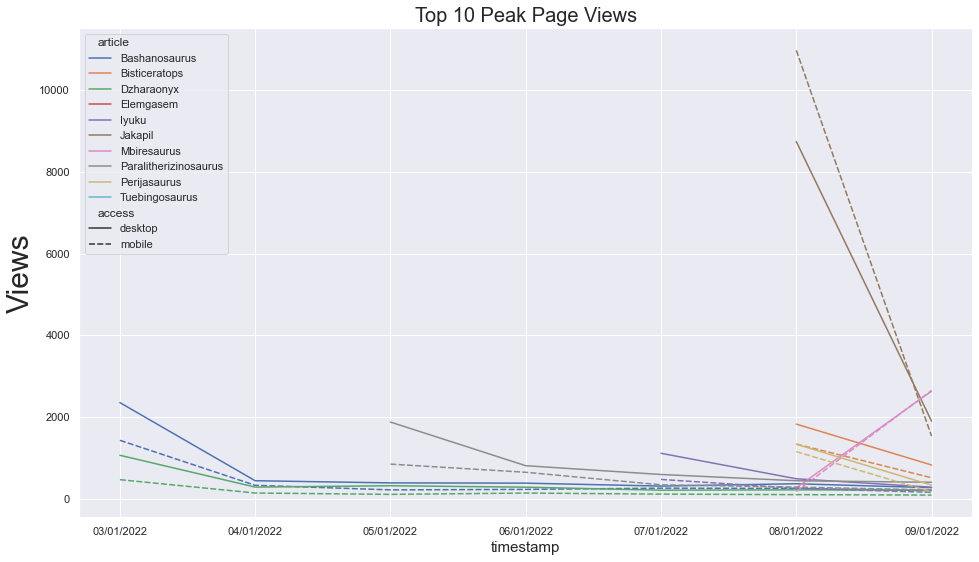

In [347]:
df_min_mths_desktop = desktop1[desktop1['article'].isin(list(desktop_2c.article))]
df_min_mths_mobile = mobile[mobile['article'].isin(list(mobile_2c.article))]

few_months_all_access = pd.concat([df_min_mths_desktop,df_min_mths_mobile],axis=0)
few_months_all_access.head()

plt.figure(figsize = (16,9))
sns.set(style='darkgrid',)
sns.lineplot(x='timestamp_1', y='views', 
             ci=None,hue='article',style='access',
             data=few_months_all_access,legend='brief')
plt.title("Top 10 Peak Page Views", fontsize = 20)
plt.xlabel("timestamp", fontsize = 15)
plt.ylabel("Views", fontsize = 30)


# Save the plot as a png file
plt.savefig('2c.png')

plt.show()